In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from hypopt import GridSearch
from scipy.io import loadmat
from scipy.stats import scoreatpercentile
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import BaseEstimator
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
from IPython.display import display, HTML

### Load datasets

In [2]:
data1 = loadmat('ex8data1.mat')
X1, X1_val, y1_val = [data1[k].astype(float) for k in ('X', 'Xval', 'yval')]
y1_val = y1_val.astype(float).reshape(-1)

data2 = loadmat('ex8data2.mat')
X2, X2_val, y2_val = [data2[k].astype(float) for k in ('X', 'Xval', 'yval')]
y2_val = y2_val.astype(float).reshape(-1)

### Dataset with features in $\mathbb{R}^2$

In [3]:
class MyEllipticEnvelope(EllipticEnvelope):
    
    def score(self, X, y, sample_weight=None):
        return f1_score(y, self.predict(X), pos_label=-1, sample_weight=sample_weight)

In [4]:
def best_elliptic_enveloppe(X, Xval, yval):
    gs = GridSearch(model = MyEllipticEnvelope(), num_threads=8)
                    
    # replace (0,1) classes to (1,-1), to match EllipticEnvelope predictions.
    model = gs.fit(X_train = X,
           y_train = None,
           param_grid = {'contamination': np.linspace(0, 0.05, 200)},
           X_val = Xval,
           y_val = yval * -2 + 1)
    print(f'Elliptic Envelopp best score: {gs.get_best_score()}')
    print(gs.get_best_params())
    best = MyEllipticEnvelope(contamination=gs.get_best_params()['contamination'])
    best.fit(X)
    return best

Comparing 200 parameter setting(s) using 8 CPU thread(s) ( 25 job(s) per thread ).
Elliptic Envelopp best score: 0.8750000000000001
{'contamination': 0.016331658291457288}
MyEllipticEnvelope score: 0.8750000000000001


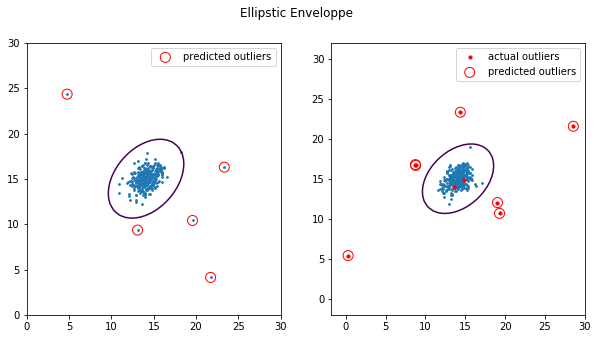

In [5]:
def plot_best_elliptic_enveloppe(X, Xval, yval):
    ell = best_elliptic_enveloppe(X, Xval, yval)
    y_pred, yval_pred = ell.predict(X), ell.predict(Xval)
    print(f'MyEllipticEnvelope score: {ell.score(Xval, yval * -2 + 1)}')

    step = 50
    xs, ys = np.meshgrid(np.linspace(0,30,step), np.linspace(0,30,step))
    zs = ell.decision_function(np.dstack((xs,ys)).reshape(-1,2)).reshape(step,step)

    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.scatter(*X.T, s=3)
    plt.contour(xs,ys,zs, levels=0)
    plt.scatter(*X[y_pred == -1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    
    plt.subplot(122)
    plt.scatter(*Xval.T, s=3)
    plt.contour(xs,ys,zs, levels=0)
    plt.scatter(*Xval[yval == 1].T, s=10, c='r', label='actual outliers');
    plt.scatter(*Xval[yval_pred == -1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    
    plt.suptitle('Ellipstic Enveloppe')
    plt.axis('equal')
    
plot_best_elliptic_enveloppe(X1, X1_val, y1_val)

In [6]:
class GaussianEstimator(BaseEstimator):
    
    def __init__(self, threshold=0.05):
        #super().__init__()
        self.threshold = threshold
        
    def fit(self, X, y=None, sample_weight=None):
        self.mu_ = np.mean(X, axis=0)
        self.sigma_ = np.cov(X, rowvar=False)
    
    def predict(self, X):
        probs = self.decision_function(X)
        return np.array(probs < self.threshold).astype(int)
    
    def decision_function(self, X):
        X_norm = X - self.mu_
        num = np.exp(-0.5 * np.diag(X_norm @ np.linalg.inv(self.sigma_) @ X_norm.T))
        den = np.sqrt((2*np.pi)**X.shape[1] * np.linalg.det(self.sigma_))
        return num / den

    def score(self, X, y, sample_weight=None):
        return f1_score(y, self.predict(X), sample_weight=sample_weight)

In [7]:
def best_gaussian_estimator(X, Xval, yval):
    pdf = multivariate_normal(mean=X.mean(0), cov=np.cov(X, rowvar=False)).pdf(X)
    gs = GridSearch(model = GaussianEstimator(), num_threads=8)
    model = gs.fit(X_train = X,
           y_train = None,
           param_grid = {'threshold': np.linspace(pdf.min(), pdf.max(), 10000)},
           X_val = Xval,
           y_val = yval)
    print(f'Multivariate Gaussian best score: {gs.get_best_score()}')
    print(gs.get_best_params())
    best = GaussianEstimator(threshold=gs.get_best_params()['threshold'])
    best.fit(X)
    return best

Comparing 10000 parameter setting(s) using 8 CPU thread(s) ( 1250 job(s) per thread ).
Multivariate Gaussian best score: 0.8750000000000001
{'threshold': 0.00027097893860860794}
GaussianEstimator score: 0.8750000000000001


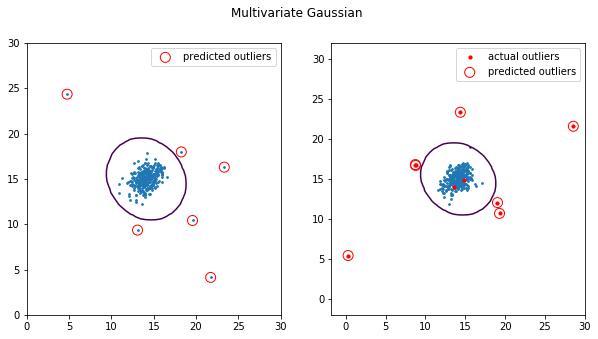

In [8]:
def plot_best_gaussian_estimator(X, Xval, yval):
    gauss = best_gaussian_estimator(X, Xval, yval)
    y_pred, yval_pred = gauss.predict(X), gauss.predict(Xval)
    print(f'GaussianEstimator score: {gauss.score(Xval, yval)}')

    step = 50
    xs, ys = np.meshgrid(np.linspace(0,30,step), np.linspace(0,30,step))
    zs = gauss.decision_function(np.dstack((xs,ys)).reshape(-1,2)).reshape(step,step)
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(121)
    plt.scatter(*X.T, s=3)
    plt.contour(xs,ys,zs, levels=[gauss.threshold])
    plt.scatter(*X[y_pred == 1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    
    plt.subplot(122)
    plt.scatter(*Xval.T, s=3)
    plt.contour(xs,ys,zs, levels=[gauss.threshold])
    plt.scatter(*Xval[yval == 1].T, s=10, c='r', label='actual outliers');
    plt.scatter(*Xval[yval_pred == 1].T, s=100, c='', edgecolors='r', label='predicted outliers');
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.legend()
    
    plt.suptitle('Multivariate Gaussian')
    plt.axis('equal')
    
plot_best_gaussian_estimator(X1, X1_val, y1_val)

### High Dimensional Dataset

In [9]:
best_gaussian_estimator(X2, X2_val, y2_val)

Comparing 10000 parameter setting(s) using 8 CPU thread(s) ( 1250 job(s) per thread ).
Multivariate Gaussian best score: 0.7368421052631577
{'threshold': 3.236645339560881e-19}


GaussianEstimator(threshold=3.236645339560881e-19)

In [10]:
best_elliptic_enveloppe(X2, X2_val, y2_val)

Comparing 200 parameter setting(s) using 8 CPU thread(s) ( 25 job(s) per thread ).
Elliptic Envelopp best score: 0.7499999999999999
{'contamination': 0.008793969849246233}


MyEllipticEnvelope(assume_centered=False, contamination=0.008793969849246233,
          random_state=None, store_precision=True, support_fraction=None)